# Orders Data Analysis

**Notebook Objective**

In this notebook we'll take a closer look at the **Orders** data from Brazilian e-commerce platform **Olist**. In the first two sections we'll do some exploratory data analysis by examining the distributions of features and look for any correlation. Then, in the final three sections we'll apply various models to further understand the relationship between the **review score** with all other features.

***Exploratory Data Analysis***
1. Distributions
2. Correlations

***Models***

3. Univariate Linear Regression
4. Multivariate Linear Regression
5. Logistic Regression


In [1]:
# Auto reload imported module every time a cell is executed
%load_ext autoreload
%autoreload 2

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
# Load the data
from olist.data import Olist
from olist.order import Order
olist=Olist()
data=olist.get_data()

## Distributions

Let's begin by analyzing features from the **Orders** data and understanding their distributions. We'll examine them in smaller groups:
- `wait_time`, `expected_wait_time`, and `delay_vs_expected`
- `dim_is_five_star`, `dim_is_one_star`, and `review_score`
- `number_of_products`, `number_of_sellers`, `price`, and `freight_value`

In [7]:
# Get summary stats for each column
orders = Order().get_training_data()
orders.describe()

,wait_time,expected_wait_time,delay_vs_expected,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value
count,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000,97007.000000
mean,12.564574,23.747123,0.774420,0.589061,0.100539,4.142237,1.142598,1.013968,136.895781,22.780658
std,9.542359,8.762100,4.747827,0.492007,0.300719,1.296559,0.540014,0.123772,208.701803,21.532648
min,0.533414,2.008009,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.850000,0.000000
25%,6.771296,18.337187,0.000000,0.000000,0.000000,4.000000,1.000000,1.000000,45.900000,13.850000
50%,10.225243,23.235741,0.000000,1.000000,0.000000,5.000000,1.000000,1.000000,86.000000,17.170000
75%,15.732506,28.416094,0.000000,1.000000,0.000000,5.000000,1.000000,1.000000,149.900000,24.020000
max,209.628611,155.135463,188.975081,1.000000,1.000000,5.000000,21.000000,5.000000,13440.000000,1794.960000


In [8]:
# Inspect data types and look for null values
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97007 entries, 0 to 97014
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            97007 non-null  object 
 1   wait_time           97007 non-null  float64
 2   expected_wait_time  97007 non-null  float64
 3   delay_vs_expected   97007 non-null  float64
 4   order_status        97007 non-null  object 
 5   dim_is_five_star    97007 non-null  int64  
 6   dim_is_one_star     97007 non-null  int64  
 7   review_score        97007 non-null  int64  
 8   number_of_products  97007 non-null  int64  
 9   number_of_sellers   97007 non-null  int64  
 10  price               97007 non-null  float64
 11  freight_value       97007 non-null  float64
dtypes: float64(5), int64(5), object(2)
memory usage: 9.6+ MB


### Distributions for `wait_time`, `expected_wait_time`, and `delay_vs_expected`

This first grouping of features relate to time and expectations for each order.

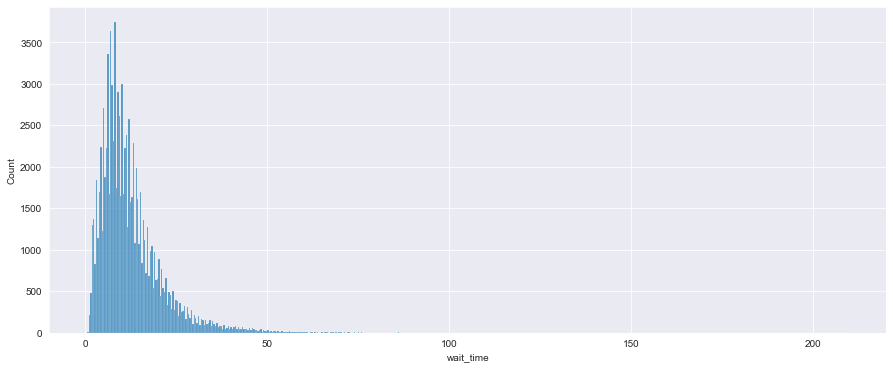

In [9]:
# 'wait_time' histogram
sns.set_style('darkgrid')
plt.figure(figsize=(15,6))
sns.histplot(orders.wait_time);

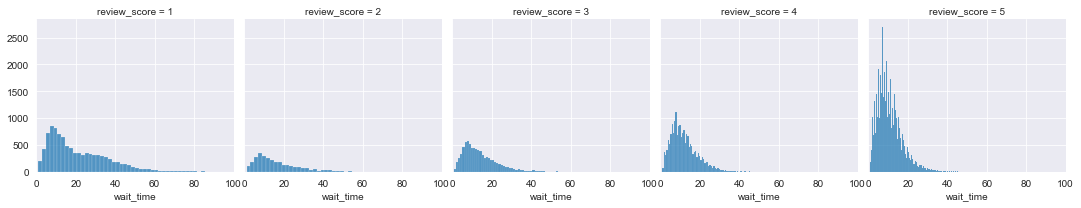

In [10]:
# Let's look at the distribution of 'wait_time' by review_score
g = sns.FacetGrid(data=orders, col='review_score')
g.map(sns.histplot, 'wait_time')
g.set(xlim=(0,100))
plt.show();

If we look at the change in shape of the distribution for `wait_time` across the various review scores, we can see that the **lower** the score, the **flatter and more right-skewed** the shape becomes. This suggests that lower scores are more likely to be associated with a longer `wait_time` for their order deliveries. 

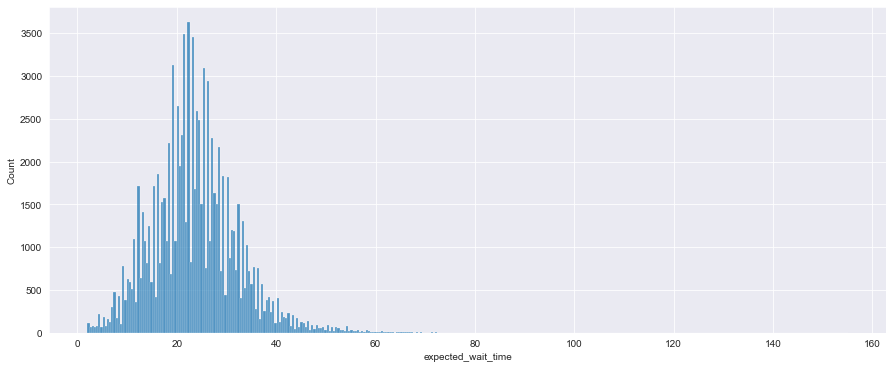

In [11]:
#'expected_wait_time' histogram
plt.figure(figsize=(15,6))
sns.histplot(orders.expected_wait_time);

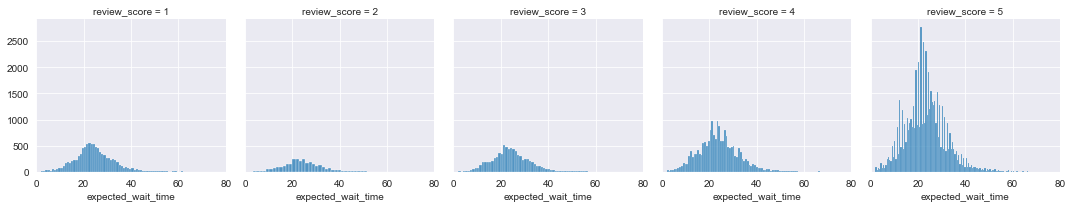

In [12]:
g1 = sns.FacetGrid(data=orders, col='review_score')
g1.set(xlim=(0,80))
g1.map(sns.histplot, 'expected_wait_time');

With `expected_wait_time`, which represents the projected time from order to delivery that has been given to a customer, we see a roughly symmetrical distribution with average time of ~23 days across all review scores. While we see higher peaks with the higher review scores of 4 and 5, there is a less clear pattern when including the lower scores. We'll check a little later to see if the difference in peaks for each score is just a reflection of the distribution of `review_score` in the data, and not necessarily associated with `expected_wait_time`.  



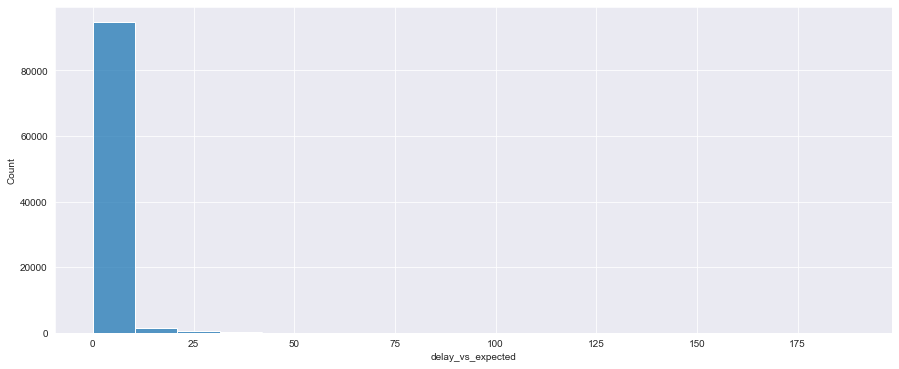

In [13]:
#'delay_vs_expected' histogram
plt.figure(figsize=(15,6))
sns.histplot(orders.delay_vs_expected);

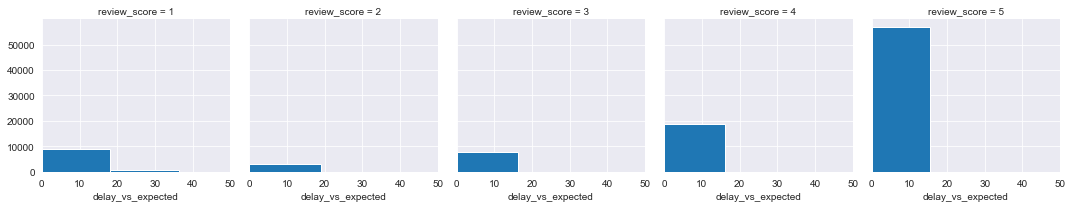

In [14]:
g2 = sns.FacetGrid(data=orders, col='review_score')
g2.set(xlim=(0,50))
g2.map(plt.hist, 'delay_vs_expected');

From the charts, it looks like *delayed orders* make up only a tiny fraction of all orders. And, among those, we see a larger share with a **`review_score` = 1**. Let's just check the numbers more precisely.

In [15]:
# Number of delayed orders
orders[orders.delay_vs_expected > 0].shape[0]

7865

In [16]:
# Number of delayed orders and receiving review score of 1
orders[(orders.delay_vs_expected > 0) & (orders.review_score == 1)].shape[0] 

3671

Out of **97,000** orders, only about **8%** are delayed, and of those that do get delayed, a **little less than half** receive **`review_score` = 1**.

### Distributions for `dim_is_five_star`, `dim_is_one_star`, and `review_score`

This grouping represents the target variables in our analysis. The variables `dim_is_five_star` and `dim_is_one_star` are one-hot encodings for a `review_score` with *five stars* and *one star*, respectively.

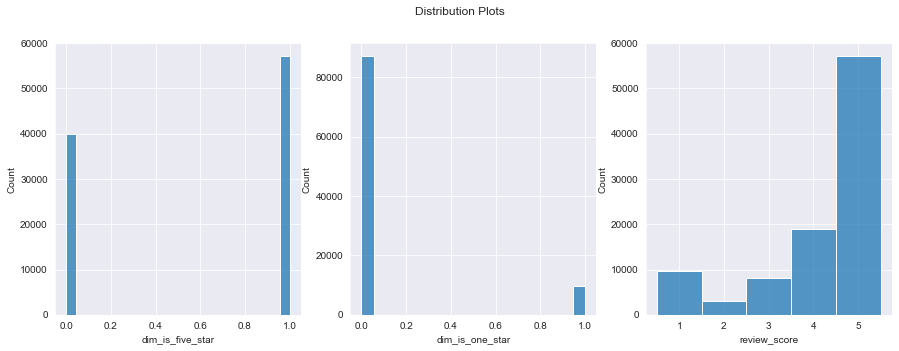

In [44]:
# Histograms of 'dim_is_five_star', 'dim_is_one_star', and 'review_score'

fig, [ax1,ax2,ax3] = plt.subplots(1,3, figsize=(15,5))

ax1 = sns.histplot(orders.dim_is_five_star, ax=ax1);

ax2 = sns.histplot(orders.dim_is_one_star, ax=ax2);

ax3 = sns.histplot(orders.review_score, discrete=True, ax=ax3)

fig.suptitle('Distribution Plots');


With this distribution of `review_score`, we can see a similar pattern that was reflected in the peak heights of the the first grouping `wait_time`, `expected_wait_time`, and `delay_vs_expected`. Namely, the lowest point is at score 2, followed by similar heights for 1 and 3, followed by a higher level for score 4, and then finally a significantly higher level for score 5. 

This suggests that for the features `expected_wait_time` and `delay_vs_expected`, the differences in heights can be attributed primarily to the underlying distribution of `review_score` in the dataset. However, with the `wait_time` feature, additional differences in skewness suggest that there is a relationship with `review_score` not only explained by the underlying distribution of `review_score`.

### Distributions for `number_of_products`, `number_of_sellers`, `price`, and `freight_value`

This grouping of features focus more on the characteristics of the order itself. 

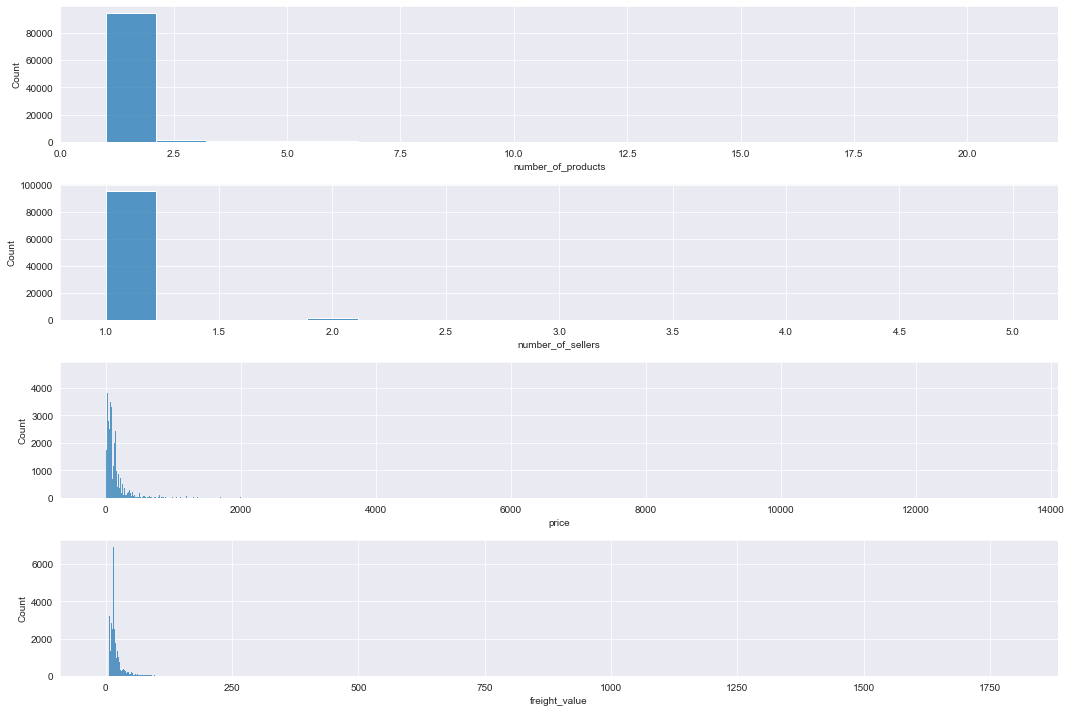

In [59]:
# Histograms for 'number_of_products','number_of_sellers','price', and 'freight_value'
fig, [ax1,ax2, ax3, ax4] = plt.subplots(4,1, figsize=(15, 10))
ax1 = sns.histplot(orders.number_of_products, ax=ax1);
ax2 = sns.histplot(orders.number_of_sellers, ax=ax2);
ax3 = sns.histplot(orders.price, ax=ax3);
ax4 = sns.histplot(orders.freight_value, ax=ax4);
fig.tight_layout()

From these histograms it's clear that there are pretty large outliers particularly for `price` and `freight_value`. Among orders, very few contain more than a single product or seller. 

Let's look at a statistical summary to get a more precise picture.

In [60]:
orders[['number_of_products', 'number_of_sellers', 'price', 'freight_value']].describe()

,number_of_products,number_of_sellers,price,freight_value
count,97007.000000,97007.000000,97007.000000,97007.000000
mean,1.142598,1.013968,136.895781,22.780658
std,0.540014,0.123772,208.701803,21.532648
min,1.000000,1.000000,0.850000,0.000000
25%,1.000000,1.000000,45.900000,13.850000
50%,1.000000,1.000000,86.000000,17.170000
75%,1.000000,1.000000,149.900000,24.020000
max,21.000000,5.000000,13440.000000,1794.960000


If we look at the middle 50% of all orders, the order value falss in the range of **45-150 BRL** (10-30 USD), and shipping costs fall in the range of **14-24 BRL** (3-5 USD).

## Correlations

Let's look to see if there are correlations between features in the Orders dataset

In [ ]:
# Use heatmap to detect correlations with 'review_score'
plt.figure(figsize=(15,6))
sns.heatmap(orders.corr(), cmap='coolwarm', annot=True);

The features `wait_time` and `delay_vs_expected` appear to have the strongest correlation with `review_score`.

In [ ]:
# Let's look at the values of the correlation coefficients
orders.corr()['review_score']

While the features `wait_time` and `delay_vs_expected` had higher correlations with our target variable `review_score` compared to the other features in our data, both features (`wait_time` and `delay_vs_expected`) are also highly correlated with each other (r=0.707), which makes sense since they both capture components of delivery duration for each customer's order. 

Since features that are highly correlated with each may be concealing a confounding variable and provide us with unreliable coefficients, we'll run some multivariate regression models that can provide a clearer sense of the impact from each feature on `review_score` while controlling for the others.

In [ ]:
orders.corr()['wait_time']

## Univariate Regression

Since the correlation coefficients for the features `wait_time` (r=33%) and `delay_vs_expected` (r=27%) have a stronger correlation with `review_score`, let's first look at them individually by running univariate regressions.


In [ ]:
import statsmodels.formula.api as smf

### Simple regression of `review_score` against `wait_time`

In [ ]:
formula = 'review_score ~ wait_time'
model1 = smf.ols(formula=formula, data=orders).fit()
model1.summary()

**Interpretation of Results**

For every additional day of `wait_time`, we can say with a 95% confidence level that the `review_score` is reduced by 4.6% on average (slope = -0.046). This suggests that there is an association between a longer `wait_time` and a lower `review_score`. 

- With a p-value close to zero, our coefficient for `wait_time` is statistically significant. 
- The R-squared indicates that 11% of the variance found in the `review_score` is attributable to `wait_time`.
- Since within the 95% confidence interval the slope does not contain the value zero, we can accept the coefficient as reliable

In [ ]:
# Let's plot the univariate regression of 'review_score' on 'wait_time'
sns.regplot(x=orders.wait_time, y=orders.review_score, y_jitter=0.1)
plt.ylim(bottom=0);

### Simple regression of `review_score` against `delay_vs_expected`

In [ ]:
formula = 'review_score ~ delay_vs_expected'
model2 = smf.ols(formula=formula, data=orders).fit()
model2.summary()

**Interpretation of Results**

For each additional day of delay that the customer waits beyond the expected delivery date, we can say with a 95% confidence level that the `review_score` is reduced by 7.4% on average (slope = -0.074). This suggests that there is an association between delays in delivery and a lower `review_score`.   

- With a p-value close to zero, the coefficient for `delay_vs_expected` is statistically significant.
- The R-squared indicates that 7% of the variance found in the `review_score` is attributable to `delay_vs_expected`.
- Since within the 95% confidence interval the slope does not contain the value zero, we can accept the coefficient as reliable

In [ ]:
# Let's plot the univariate regression of 'review_score' on 'delay_vs_expected'
sns.regplot(x=orders.delay_vs_expected, y=orders.review_score, y_jitter=0.1)
plt.ylim(bottom=0);

## Multivariate Regression

While the features `wait_time` and `delay_vs_expected` had higher correlations with our target variable `review_score` compared to the other features in our data, both features (`wait_time` and `delay_vs_expected`) are also highly correlated with each other (r=0.707), which makes sense since they both capture components of delivery duration for each customer's order. 

Since features that are highly correlated with each may be concealing a confounding variable and provide us with unreliable coefficients, we'll run some multivariate regression models that can provide a clearer sense of the impact from each feature on `review_score` while controlling for the others.

In [ ]:
orders.corr()['wait_time']

### Multivariate Regression with 2 features: `wait_time` and `delay_vs_expected`
First, we'll regress `review_score` on just the two features `wait_time` and `delay_vs_expected`.

In [ ]:
model3 = smf.ols('review_score ~ wait_time + delay_vs_expected', data=orders).fit()
model3.summary()

**Interpretation of Results**

While holding `delay_vs_expected` constant, each additional day of `wait_time` reduces the `review_score` by **3.8%** on average (slope = -0.0388). 

While holding `wait_time` constant, each additional day of `delay_vs_expected` reduces the `review_score` by **1.9%** on average (slope = -0.0191).

Therefore, in contrast to our univariate analysis, which suggested `delay_vs_expected` (**-7.4%**) has a stronger association with low `review_scores` than `wait_time` (**-4.6%**), we find the opposite to be the case in our multivariate analysis.

With a multivariate regression model that considered both features, the `wait_time` (**-3.9%**) has a stronger association with low `review_scores` than `delay_vs_expected` (**-1.9%**).

- Both features show ***p-values*** close to zero indicating that they are **statistically significant**
- Within the ***95% confidence interval***, slopes for the partial coefficients do not contain zero which allows us to consider them reliable
- ***R-squared*** is relatively low: only **11.5%** of the variations of `review_score` is explained by the variation of `wait_time` and `delay_vs_expected`

With these findings we can make the case that for the customer, the total wait time (from placing the order online to getting the package at the front door) has more impact on the review score than an order that arrives past the estimated delivery date. 

Therefore, for a CEO or manager hoping to improve order review scores, efforts to reduce the total wait time (perhaps in improving speed and efficiency in order processing or logistics handling) will do more than only trying to meet estimated delivery deadlines.


### Multivariate Regression with multiple features

Since the R-squared in our previous model with only two features was relatively low, in our next model we'll add other features from our data to build a more complete picture of what factors impact the order `review_score`. 

In [ ]:
# Features to include in the model
features = [
    "wait_time",
    "delay_vs_expected",
    "number_of_products",
    "number_of_sellers",
    "price",
    "freight_value"]

Because these features are in different units, we'll standardize them first before putting them into our regression model. 

In [ ]:
# standardize features by calculating respective z-scores:   Z = (X - mu) / sigma

orders_standardized = orders.copy()
for f in features:
    mu = orders[f].mean()
    sigma = orders[f].std()
    orders_standardized[f] = orders[f].map(lambda x: (x - mu) / sigma)

orders_standardized.head()

In [ ]:
# model4; create formula for stats.model

formula = 'review_score ~ ' + ' + ' .join(features)
formula

In [ ]:
model4 = smf.ols(formula = formula, data = orders_standardized).fit()
model4.summary()

To more easily compare the various partial coefficents of the features, we'll plot them on a bar chart.

In [ ]:
model4.params[1:].sort_values().plot(kind='barh')
plt.xlabel('Regression Partial Coefficients')
plt.ylabel('Features');

**Interpretation of Results**

With our new regression model including other features from our dataset, the `wait_time` variable (slope = -0.3898) has the most explanatory power for `review_score` relative to the other features. In this model, in comparison to `wait_time`, the difference in influence has widened with `delay_vs_expected` (slope = -0.0816)

Additionally, with this model, we can see that an increase in `number_of_sellers` and `number_of_products` per order, shows a decrease in `review_score`.

- The ***R-squared*** for this new model has not increased much and still only explains about 14.1% of the variance in the `review_score`. This points to most factors impacting the review score lying outside of the orders dataset.
- The ***p-values*** for our partial coefficients are mostly close to zero. However, the coefficient for `price` is small relative to its standard error, and its 95% confidence interval for is close to containing the value of zero, which would make the coefficient less reliable.   
- The overall model is **statistically significant** as its F-statistic is much greater than 1 (and a F-proba close to zero)

 ### Residuals

Besides evaluating the statistical signficance of our features and the R-squared of our model, we should also make sure the residuals are:
 - not correlated with one another (autocorrelation)
 - normally distributed 
 - constant variance (i.e. not exhibiting heteroscedasticity)
 

In [ ]:
# Residuals = predicted values - real values
predicted_review_score = model4.predict(orders_standardized[features])
residuals = predicted_review_score - orders_standardized.review_score
residuals.head()

**Check the Durbin-Watson test for autocorrelation**

With a scale of 0-4 (with 0 indicating positively autocorrelated, and 4 indicating negatively autocorrelated), our value of **2.009** allows to say that there is little autocorrelation among the residuals. Autocorrelation among residuals would imply that our confidence intervals are narrower and p-values lower than they ought to be, allowing us to be more confident than we should be with our findings.

**Check the Jarque-Bera test for normality & plot the distribution**

The Jarque-Bera statistic (normal=0) measures skewness and kurtosis to assess normality. A large value like **36369.606** indicates
that the distribution is not normal. With a p-value close to zero, this is statistically significant.


In [ ]:
# Let's confirm this with a density plot of the residulas
sns.histplot(residuals, kde=True, stat='density', discrete=True)
plt.title('residuals density plot');

As we can see the numerous humps in the plot, this distribution does not look normal....

**Check the variance of the residuals for heteroskedasticity**

In [ ]:
# Let's check the variance by plotting the residuals against the fitted values
sns.scatterplot(y=residuals, x=predicted_review_score);

In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan as bp

bp_results = bp(residuals, exog_het=orders_standardized[features])
bp_results



**Conclusion**

We can start to see that a linear regression model is failing along some basic assumptions (e.g. normality of residuals) and poor performance (e.g. R-squared is low). Since our review score (five-star rating system) is a categorical variable, we'll now look at applying a logistic regression model

# Logistic Regression

For our logistic regression models, we'll see how features have an impact on very poor 1-star reviews (`dim_is_one_star`) and on very good 5-star reviews (`dim_is_five_star`). 

Let's stick with the same features from our multivariate linear regression that had statistically significant partial coefficients.

In [ ]:
features = ['wait_time', 'delay_vs_expected', 'number_of_products', 'number_of_sellers', 'price', 'freight_value']

To make sure we have a degree of collinearity among these features that isn't too high (vif < 10), let's look at the Variance Inflation Factor (vif). 

In [ ]:
# Check for multi-colinearity by looking at Variance Inflation Factor (vif)
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
X = orders[features]
X

In [ ]:
df = pd.DataFrame()
df['vif_index'] = [vif(X.values, i) for i in range(X.shape[1])]
df['features'] = X.columns
df

In [ ]:
df = pd.DataFrame()
df['vif_index'] = [vif(X.values, i) for i in range(X.shape[1])]
df['features'] = X.columns
df

In [ ]:
# Use heatmap to detect correlations with 'review_score'
plt.figure(figsize=(15,6))
sns.heatmap(orders.corr(), cmap='coolwarm');

In [ ]:
# Let's look at the values of the correlation coefficients
orders.corr()['review_score']

After noticing the high multi-collinearity between features, we can remove `number_of_sellers` and `price` to reduce the VIF for the remaining features.

In [ ]:
# Fitting 2 LOGIT models (logit_one and logit_five) to predict dim_is_one_star and dim_is_five_star
logit_one = smf.logit(formula='dim_is_one_star ~' + ' + '.join(features), data=orders).fit()
print(logit_one.summary())

In [ ]:
logit_five = smf.logit(formula='dim_is_five_star ~' + ' + '.join(features), data=orders).fit()
print(logit_five.summary())

In [ ]:
#Compare against Ordinary Least Squares (OLS) Regression 
linear_model = smf.ols(formula='review_score ~' + ' + '.join(features), data=orders).fit()
print(linear_model.summary())

In [ ]:
plt.figure(figsize=(13,5))
plt.suptitle('Linear vs. Logit Coefficients')
ax1 = plt.subplot(1,2,1)
ax1.set_title('Linear')
ax1.set_xlim(-1.5, 0.25)
linear_model.params[1:].sort_values().plot(kind='barh', ax=ax1)

ax2 = plt.subplot(1,2,2)
ax2.set_title('Logit')
ax2.yaxis.tick_right()
ax2.set_xlim(-1.5, 0.25)
logit_five.params[1:].sort_values().plot(kind='barh', ax=ax2)

plt.show()



In [ ]:
# According to the R-squared,roughly 14% of the variance can be explained from the selected features

In [ ]:
#Use ANOVA correlation test - 